# Urban growth modeling in GRASS GIS: Parallel computing case study
The purpose of this notebook is to demonstrate several parallel computing principles and how they are implemented in GRASS GIS.
We use FUTURES urban growth model implemented as a GRASS GIS addon [r.futures](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.html).

This notebook requires prepared dataset available here. This dataset is a GRASS GIS Location containing:
 * [NLCD 2001-2019](https://www.mrlc.gov/) (land use and impervious surface descriptor)
 * [US county boundaries](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)
 * [US-PAD protected areas](https://www.usgs.gov/programs/gap-analysis-project/science/pad-us-data-overview)
 * [USGS DEM](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services)

The required software includes
 * _GRASS GIS v8.2_ with the following addons: _r.futures, r.mapcalc.tiled, r.sample.category_
 * _R_ with the following packages: _lme4, optparse, MuMIn, snow_
 * _GNU Parallel_
 * _Python 3_ with packages _pandas_
 
See [documentation](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html) how to use GRASS GIS in a Jupyter Notebook.

The expected computing resources for the notebook as intended are 12 cores and 32GB memory.

In [19]:
nprocs = 12

This notebook combines Python 3 and Bash cells. By default a code cell is in Python. We use IPython [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cell-magics) including `%%bash`, `%%time`, and `%%writefile`.

## Setting up
Create a directory on your disk with enough disk space (100GB), unzip FUTURES_SE_USA.zip and population_SE_counties_2001-2100_SSP2.zip:
```
├── FUTURES_SE_USA
│   ├── PERMANENT
│   └── tutorial
├── observed_population_SE_counties_2001-2019.csv
└── projected_population_SE_counties_2020-2100_SSP2.csv

```

Change the current directory to wherever you unzipped the data, example below (modify as needed):

In [20]:
import os

os.chdir("/data/FUTURES_case_study/")


Import Python packages and initialize GRASS GIS session:

In [21]:
import subprocess
import sys
import pathlib
import json
import pandas as pd
from IPython.display import Image

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass8", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init(".", "FUTURES", "tutorial")


Install GRASS addons:

In [ ]:
gs.run_command("g.extension", extension="r.futures")
gs.run_command("g.extension", extension="r.mapcalc.tiled")
gs.run_command("g.extension", extension="r.sample.category")


## Data preprocessing

List dataset layers:

In [ ]:
%%bash
g.list type=raster,vector -p


### Process county boundaries
Extract states in South-East US (Alabama, Florida, Georgia, North carolina, South Carolina, Tennessee)
and convert

In [ ]:
%%bash
v.extract tl_2021_us_county output=SE_counties where="STATEFP in ('01', '12', '13', '37', '45', '47')" --q
v.db.addcolumn SE_counties column="state integer" --q
v.db.addcolumn SE_counties column="county integer" --q
v.db.update SE_counties col=state qcol="CAST(STATEFP AS integer)" --q
v.db.update SE_counties col=county qcol="CAST(GEOID AS integer)" --q


In [ ]:
m = gj.Map()
m.d_vect(map="SE_counties")
m.show()


Split and rasterize states for further parallelization steps:

In [22]:
states = [1, 12, 13, 37, 45, 47]

In [ ]:
gs.use_temp_region()
for state in states:
    gs.run_command(
        "v.extract",
        input="SE_counties",
        where=f"state == '{state}'",
        output=f"state_{state}",
    )
    gs.run_command("g.region", vector=f"state_{state}", align="nlcd_2019")
    gs.run_command(
        "v.to.rast",
        input=f"state_{state}",
        output=f"state_{state}",
        use="attr",
        attribute_column="county",
    )
gs.del_temp_region()


### DEM to slope
Compute slope with r.slope.aspect which uses OpenMP for parallelization:

In [23]:
%%timeit -n1 -r5
gs.run_command(
    "r.slope.aspect", elevation="DEM", slope="slope", flags="e", nprocs=nprocs
)


55.5 s ± 367 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [24]:
%%timeit -n1 -r5
gs.run_command(
    "r.slope.aspect", elevation="DEM", slope="slope", flags="e", nprocs=1
)


2min 29s ± 126 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


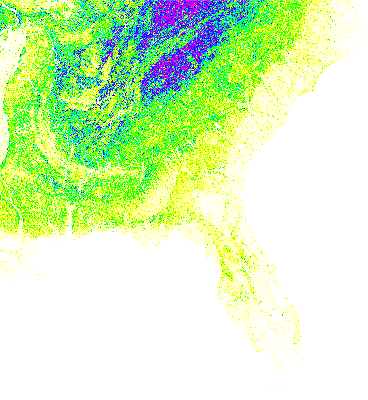

In [25]:
m = gj.Map()
m.d_rast(map="slope")
m.show()


### Protected land
Rasterize protected areas to later include them in a mask. We use GridModule to split the computation in tiles:

In [114]:
%%python
import time
from grass.pygrass.modules.grid import GridModule
def run():
    s = time.time()
    grid = GridModule(
        "v.to.rast",
        input="protected",
        output="protected",
        type="area",
        use="cat",
        processes=12,
        patch_backend="r.patch",
        quiet=True,
    )
    grid.run()
    return time.time() - s
sm = 0
for i in range(5):
    sm += run()
print(sm / 5)

28.531109285354614


         1
   0   0   0   0   0   0   0   0   0   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         1
   0   0   0   0   0   0   0   0   0   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         1
   0   0   0   0   0   0   0   0   0   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         1
   0   0   0   0   0   0   0   0   0   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  84  87  90  93  96  99 100
         1
   0   0   0   0   0   0   0   0   0   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [111]:
%%timeit -n1 -r5
gs.run_command("v.to.rast", input="protected", output="protected", type="area", use="cat")

53.9 s ± 343 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


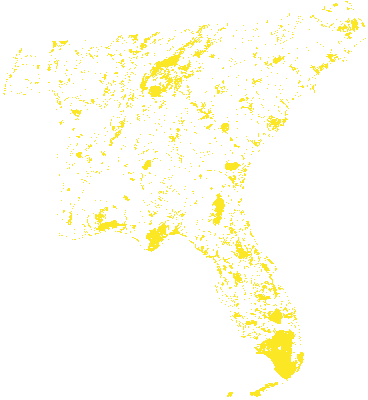

In [28]:
m = gj.Map()
m.d_rast(map="protected")
m.show()


### Process NLCD data
Most of our predictors we will derive from NLCD data (land cover type and impervious descriptor products). With r.reclass we create water, forest, roads, urban rasters.
Note that those rasters are virtual (they behave the same way, but are only pointing to the original NLCD raster),
so reclassification is very fast.

In [29]:
NLCD_years = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019]
NLCD_start_end_years = [2001, 2019]
# water (1 or no data)
gs.write_command(
    "r.reclass", input="nlcd_2019", output="water", rules="-", stdin="11 = 1"
)
# binary wetlands
gs.write_command(
    "r.reclass",
    input="nlcd_2019",
    output="wetlands",
    rules="-",
    stdin="90 95 = 1 \n * = 0",
)
for year in NLCD_years:
    gs.write_command(
        "r.reclass",
        input=f"nlcd_{year}",
        output=f"urban_{year}",
        rules="-",
        stdin="21 22 23 24 = 1\n* = 0",
    )
for year in NLCD_start_end_years:
    gs.write_command(
        "r.reclass",
        input=f"nlcd_{year}",
        output=f"forest_{year}",
        rules="-",
        stdin="41 42 43 = 1",
    )
    gs.write_command(
        "r.reclass",
        input=f"nlcd_descriptor_{year}",
        output=f"roads_{year}",
        rules="-",
        stdin="20 21 22 23 = 1",
    )
    gs.write_command(
        "r.reclass",
        input=f"nlcd_descriptor_{year}",
        output=f"urban_no_roads_{year}",
        rules="-",
        stdin="24 25 26 = 1\n* = 0",
    )

In [136]:
%%bash

time r.grow.distance input=water distance=dist_to_water -m --q && r.mapcalc "log_dist_to_water = log(dist_to_water + 1)" --q
time r.grow.distance input=forest_2001 distance=dist_to_forest_2001 -m --q && r.mapcalc "log_dist_to_forest_2001 = log(dist_to_forest_2001 + 1)" --q 
time r.grow.distance input=forest_2019 distance=dist_to_forest_2019 -m --q && r.mapcalc "log_dist_to_forest_2019 = log(dist_to_forest_2019 + 1)" --q 
time r.grow.distance input=roads_2001 distance=dist_to_roads_2001 -m --q && r.mapcalc "log_dist_to_roads_2001 = log(dist_to_roads_2001 + 1)" --q 
time r.grow.distance input=roads_2019 distance=dist_to_roads_2019 -m --q && r.mapcalc "log_dist_to_roads_2019 = log(dist_to_roads_2019 + 1)" --q 



real	4m35.121s
user	3m35.776s
sys	0m42.062s

real	4m4.349s
user	3m25.579s
sys	0m38.341s

real	4m26.527s
user	3m34.142s
sys	0m38.828s

real	4m36.011s
user	3m47.743s
sys	0m38.989s

real	4m34.237s
user	3m46.728s
sys	0m38.773s


In Bash use background processing (append &) to compute distance to water, forest, and roads in parallel since these are independent computations. Command wait forces to wait for the background processes to finish.
Once the distance is computed, we use raster algebra to transform it logarithmically.

In [74]:
%%bash
start_time=$SECONDS
for I in 1 2 3 4 5
do
r.grow.distance input=water distance=dist_to_water -m --q && r.mapcalc "log_dist_to_water = log(dist_to_water + 1)" --q &
r.grow.distance input=forest_2001 distance=dist_to_forest_2001 -m --q && r.mapcalc "log_dist_to_forest_2001 = log(dist_to_forest_2001 + 1)" --q &
r.grow.distance input=forest_2019 distance=dist_to_forest_2019 -m --q && r.mapcalc "log_dist_to_forest_2019 = log(dist_to_forest_2019 + 1)" --q &
r.grow.distance input=roads_2001 distance=dist_to_roads_2001 -m --q && r.mapcalc "log_dist_to_roads_2001 = log(dist_to_roads_2001 + 1)" --q &
r.grow.distance input=roads_2019 distance=dist_to_roads_2019 -m --q && r.mapcalc "log_dist_to_roads_2019 = log(dist_to_roads_2019 + 1)" --q &
wait
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

2643
528.6


In [75]:
%%bash
start_time=$SECONDS
for I in 1 2 3 4 5
do
r.grow.distance input=water distance=dist_to_water -m --q && r.mapcalc "log_dist_to_water = log(dist_to_water + 1)" --q
r.grow.distance input=forest_2001 distance=dist_to_forest_2001 -m --q && r.mapcalc "log_dist_to_forest_2001 = log(dist_to_forest_2001 + 1)" --q
r.grow.distance input=forest_2019 distance=dist_to_forest_2019 -m --q && r.mapcalc "log_dist_to_forest_2019 = log(dist_to_forest_2019 + 1)" --q
r.grow.distance input=roads_2001 distance=dist_to_roads_2001 -m --q && r.mapcalc "log_dist_to_roads_2001 = log(dist_to_roads_2001 + 1)" --q
r.grow.distance input=roads_2019 distance=dist_to_roads_2019 -m --q && r.mapcalc "log_dist_to_roads_2019 = log(dist_to_roads_2019 + 1)" --q
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

8911
1782.2


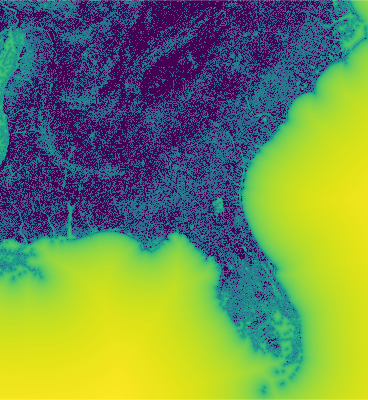

In [32]:
m = gj.Map()
m.d_rast(map="log_dist_to_forest")
m.show()


FUTURES uses a special predictor called development pressure, which can be computed with r.futures.devpressure, which is internally parallelized.
Since we need to compute it for 2 years, we use a hybrid approach which runs both command as background process and each of them runs in parallel.
To do that we split the number of available processes so that each r.futures.devpressure process gets half of the available processes:

In [76]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
r.futures.devpressure input=urban_no_roads_2001 output=devpressure_2001 size=30 gamma=0.5 nprocs=$1 scaling_factor=0.1 &
r.futures.devpressure input=urban_no_roads_2019 output=devpressure_2019 size=30 gamma=0.5 nprocs=$1 scaling_factor=0.1 &
wait
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

14565
2913.0


Running development pressure filter...
Running development pressure filter...
   0   0   0   0   0   0   0   0   0   0   0   0   3   3   6   6   9   9  12  12  15  15  18  18  21  21  24  24  27  27  30  30  33  33  36  36  39  39  42  42  45  45  48  48  51  51  54  54  57  57  60  60  63  63  66  66  69  69  72  72  75  75  78  78  81  81  84  84  87  87  90  90  93  93  96  96  99  99 100
Writing raster map <devpressure_2019>
 100
Writing raster map <devpressure_2001>
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Running development pressure filter...
Running development pressure filter...
   0   0   0   0   0   0   0   0   0   0   0   0   3   3   6   6   9   

In [77]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
r.futures.devpressure input=urban_no_roads_2001 output=devpressure_2001 size=30 gamma=0.5 nprocs=1 scaling_factor=0.1
r.futures.devpressure input=urban_no_roads_2019 output=devpressure_2019 size=30 gamma=0.5 nprocs=1 scaling_factor=0.1
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

163237
32647.4


Running development pressure filter...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map <devpressure_2001>
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Data element 'cellhd/devpressure_2001' was found in more mapsets (also
found in <test>)
Using <devpressure_2001@tutorial>...
Running development pressure filter...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map <devpressure_2019>
Running development pressure filter...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing r

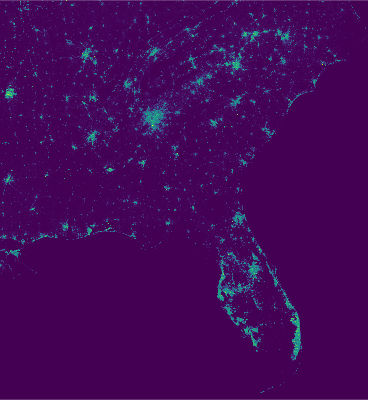

In [35]:
m = gj.Map()
m.d_rast(map="devpressure_2001")
m.show()


In [78]:
%%timeit -n1 -r5
gs.run_command(
    "r.neighbors",
    input="wetlands",
    output="wetland_density",
    size=37,
    method="average",
    flags="c",
    nprocs=nprocs,
)

9min 16s ± 2.45 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [79]:
%%timeit -n1 -r5
gs.run_command(
    "r.neighbors",
    input="wetlands",
    output="wetland_density",
    size=37,
    method="average",
    flags="c",
    nprocs=1,
)

1h 33min 13s ± 12.4 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


### Mask
Compute mask to avoid urban growth simulation in water, protected areas, and outside the study area. We use r.mapcalc.tiled:

In [57]:
%%timeit -n1 -r5
gs.run_command(
    "r.mapcalc.tiled",
    expression="masking = if((isnull(protected) &&  isnull(water) && nlcd_2019), 1, null())",
    nprocs=nprocs,
)


1min 36s ± 448 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [39]:
%%timeit -n1 -r5
gs.mapcalc("masking = if((isnull(protected) &&  isnull(water) && nlcd_2019), 1, null())")

3min 12s ± 180 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


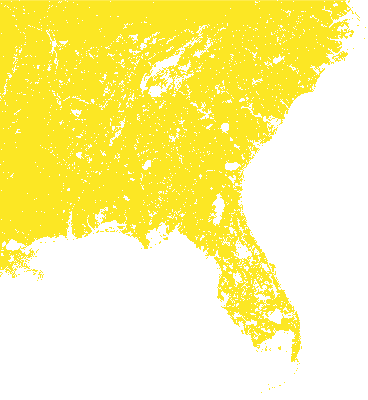

In [40]:
m = gj.Map()
m.d_rast(map="masking")
m.show()


## Demand computation
Here we compute how much land will be developed in each step of the simulation.
Logarithmic curves are fit to per-capita land consumption data derived from NLCD time series and observed population for each county.

This computation is parallelized by state. First we create a Python script that takes the state as an input parameter,
sets the computational region to the state extent, excludes roads from the computation, and runs r.futures.demand,
creating an output CSV and a plot specific to that state.

In [41]:
%%writefile demand_for_state.py
import sys
import grass.script as gs

# input parameter: state FIPS code
state = sys.argv[1]

gs.run_command("g.mapsets", mapset="tutorial", operation="add")
gs.run_command("g.region", raster=f"state_{state}")
gs.mapcalc("MASK = if (isnull(roads), 1, null())")
gs.run_command(
    "r.futures.demand",
    subregions=f"state_{state}",
    development=[
        f"urban_{year}" for year in [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019]
    ],
    observed_population="observed_population_SE_counties_2001-2019.csv",
    projected_population="projected_population_SE_counties_2020-2100_SSP2.csv",
    simulation_times=list(range(2019, 2051)),
    method="logarithmic",
    demand=f"demand_{state}.csv",
    plot=f"demand_{state}.png",
    overwrite=True,
)


Overwriting demand_for_state.py


For each state generate grass command calling the script within a temporary mapset and append the the line to a file `demand_jobs.sh`.
Run these commands in parallel with GNU Parallel.

In [42]:
%%bash -s "{nprocs}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f demand_jobs.sh
for S in 1 12 13 37 45 47
do
    echo grass8 --tmp-mapset FUTURES --exec python demand_for_state.py ${S} >> demand_jobs.sh
done
parallel -j ${1} < demand_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

1451
290.2


In [43]:
%%bash -s "{nprocs}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f demand_jobs.sh
for S in 1 12 13 37 45 47
do
    echo grass8 --tmp-mapset FUTURES --exec python demand_for_state.py ${S} >> demand_jobs.sh
done
parallel -j 1 < demand_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

4501
900.2


Visualize results for one state:

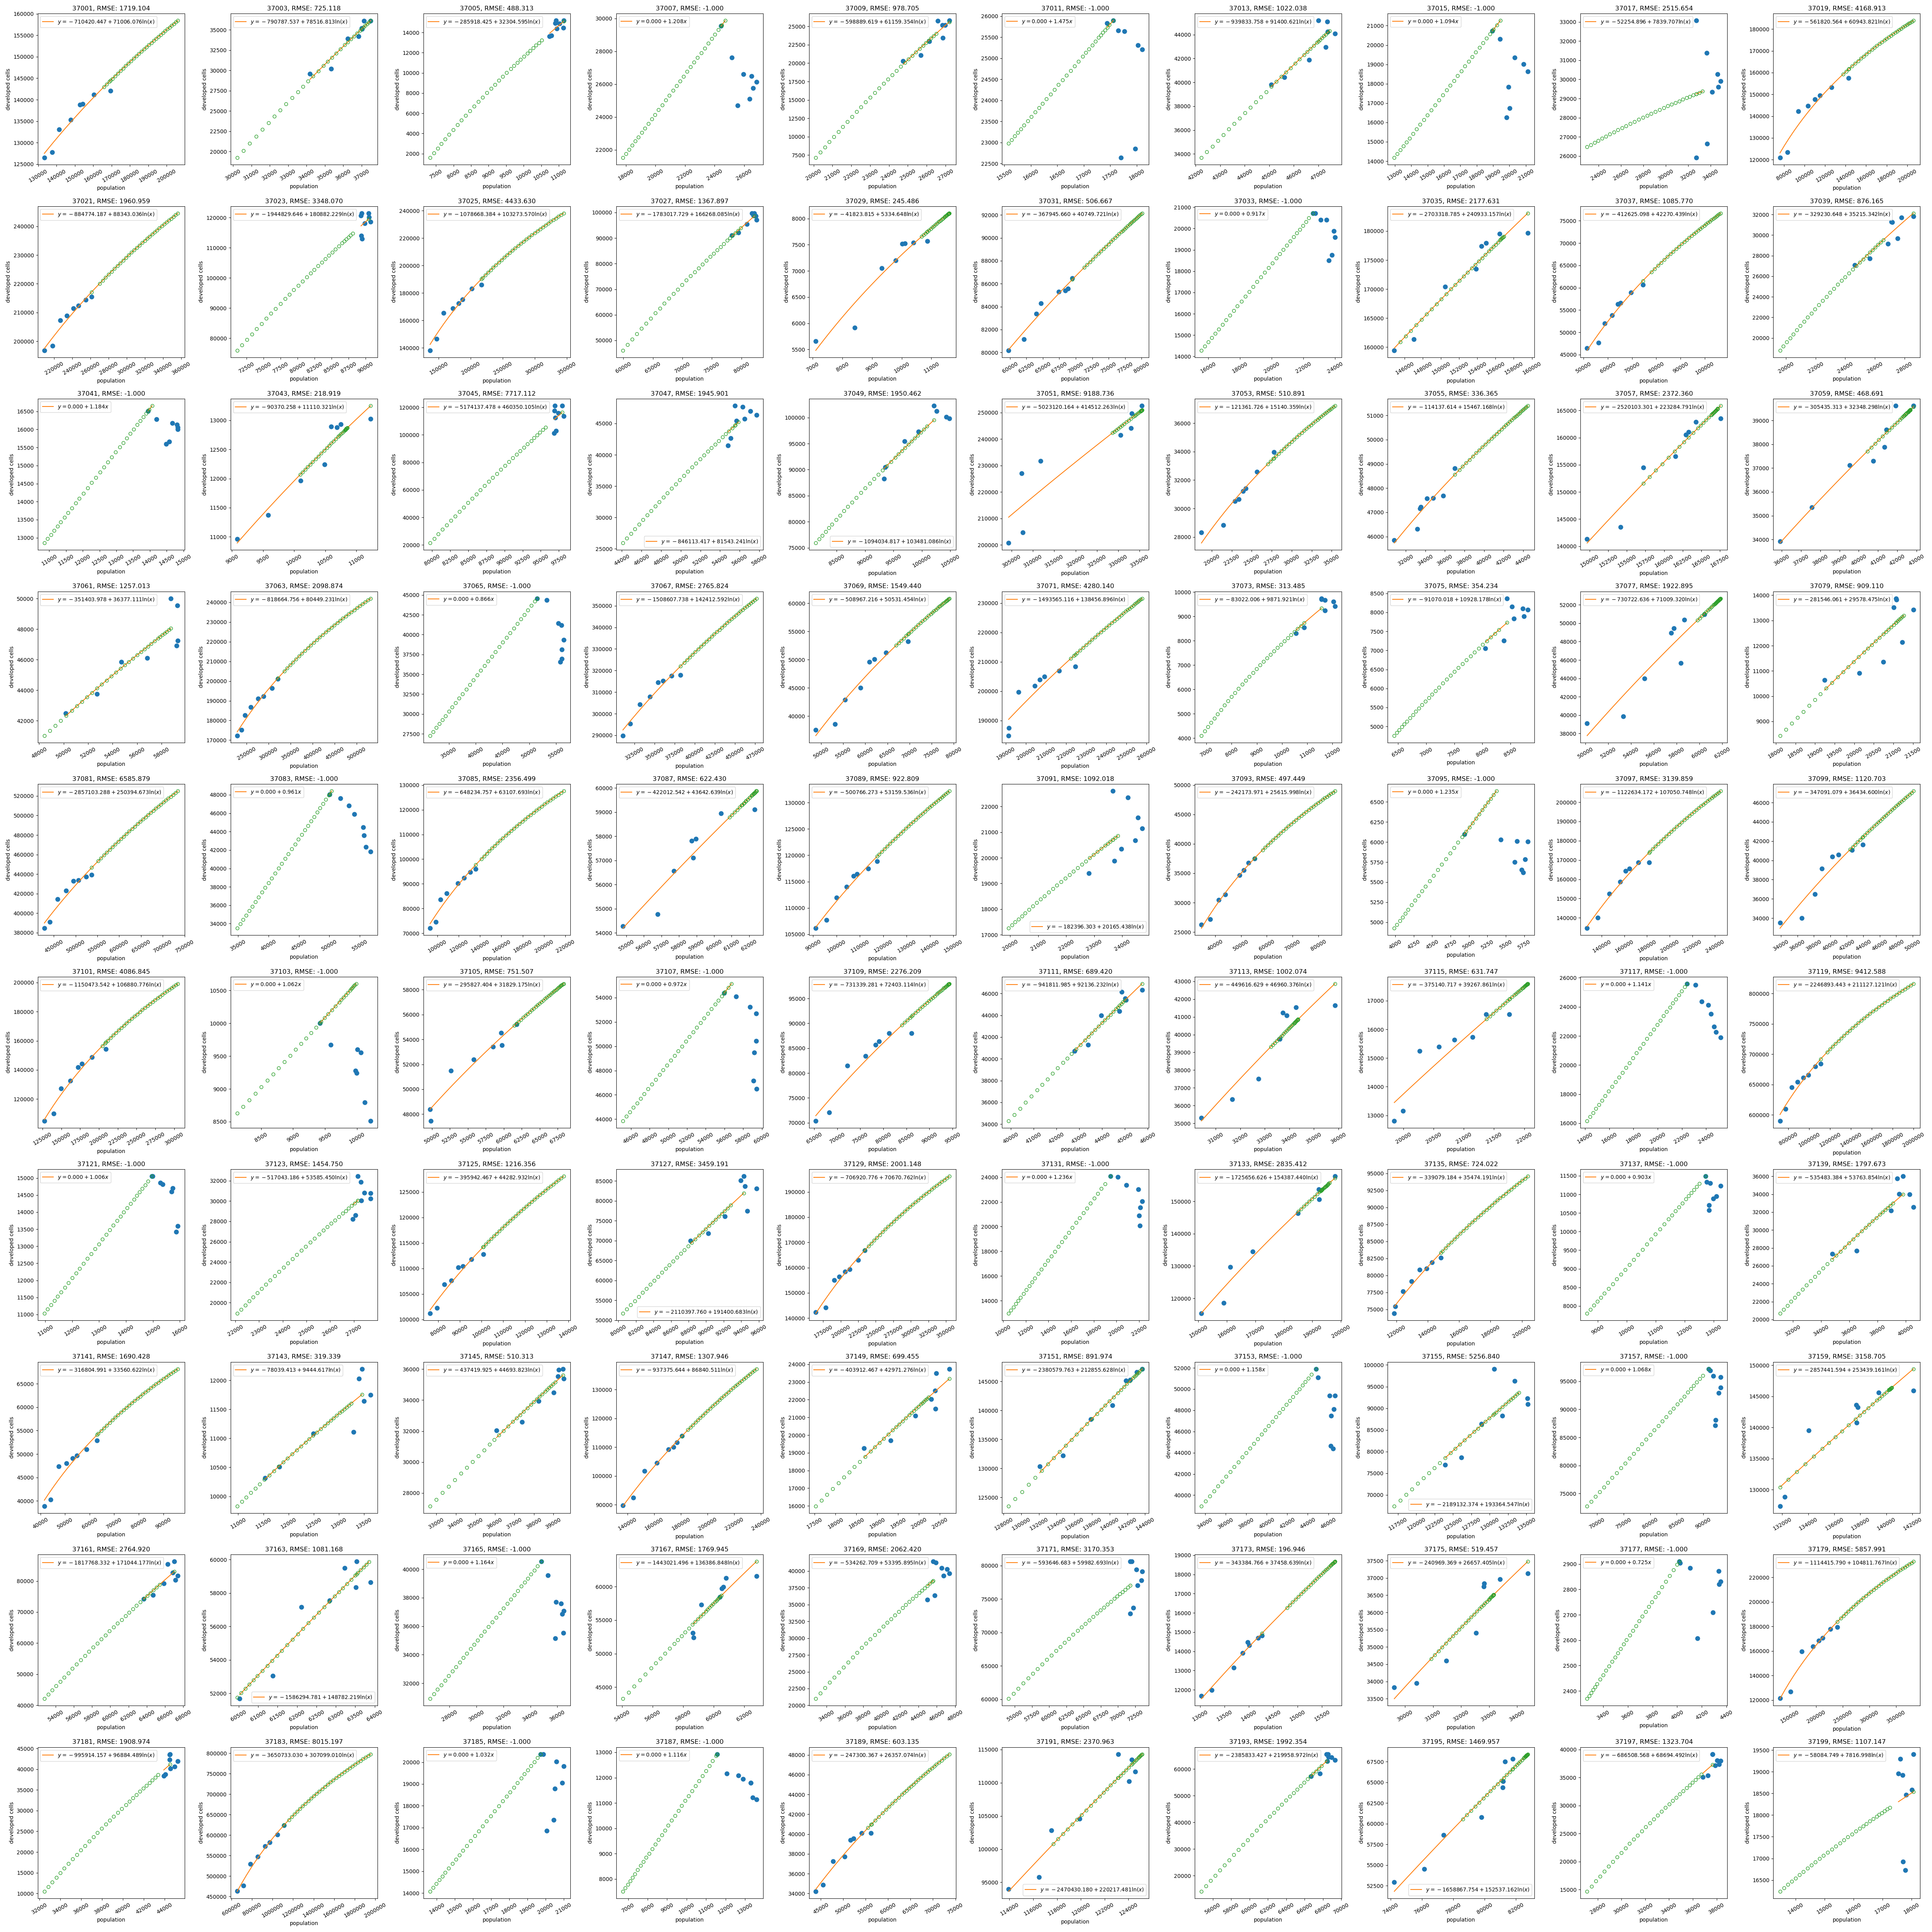

In [44]:
Image("demand_37.png")


## Development Potential
### Predictor Sampling
First we need a layer representing newly developed areas between 2001 and 2019 (value 1) and areas that didn't transition:

In [45]:
%%timeit -n1 -r5
gs.run_command(
    "r.mapcalc.tiled",
    expression="urban_change = if(urban_2001 == 0, if(urban_2019 == 1, 1, 0), null())",
    nprocs=nprocs,
)


1min 34s ± 176 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [46]:
%%timeit -n1 -r5
gs.mapcalc("urban_change = if(urban_2001 == 0, if(urban_2019 == 1, 1, 0), null())")

2min 50s ± 163 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Similarly to Demand computation, we create a script that is then executed with different states.
Since we need to patch the results together, we won't use temporary mapset.
Setting the mask ensures area outiside of it won't be sampled.

In [47]:
%%writefile sampling_for_state.py
import sys
import grass.script as gs

state = sys.argv[1]

gs.run_command("g.mapsets", mapset="tutorial", operation="add")
gs.run_command("g.region", raster=f"state_{state}")
gs.run_command("r.mask", raster=f"state_{state}")
# create an identical, virtual map of counties with different name to later simplify patching of attribute tables
gs.write_command(
    "r.reclass", input=f"state_{state}", output="counties", rules="-", stdin="* = *"
)
gs.run_command(
    "r.sample.category",
    input="urban_change",
    output=f"sample_{state}",
    sampled=[
        "counties",
        "devpressure_2001",
        "log_dist_to_forest_2001",
        "log_dist_to_roads_2001",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    npoints=[10000, 5000],
    random_seed=2,
)
gs.run_command("r.mask", flags="r")


Overwriting sampling_for_state.py


In [48]:
%%bash -s "{nprocs}"

rm -f sampling_jobs.sh
for S in 1 12 13 37 45 47
do
    # remove mapset to start fresh after previous run
    rm -rf FUTURES/sampling_${S}
    echo grass8 -c FUTURES/sampling_${S} --exec python sampling_for_state.py ${S} >> sampling_jobs.sh
done
parallel -j ${1} < sampling_jobs.sh 2> log.txt


In [80]:
%%bash -s "{nprocs}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f sampling_jobs.sh
for S in 1 12 13 37 45 47
do
    # remove mapset to start fresh after previous run
    rm -rf FUTURES/sampling_${S}
    echo grass8 -c FUTURES/sampling_${S} --exec python sampling_for_state.py ${S} >> sampling_jobs.sh
done
parallel -j ${1} < sampling_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

625
125.0


In [81]:
%%bash -s "{nprocs}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f sampling_jobs.sh
for S in 1 12 13 37 45 47
do
    # remove mapset to start fresh after previous run
    rm -rf FUTURES/sampling_${S}
    echo grass8 -c FUTURES/sampling_${S} --exec python sampling_for_state.py ${S} >> sampling_jobs.sh
done
parallel -j 1 < sampling_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

2188
437.6


Here we patch the results:

In [51]:
gs.run_command(
    "v.patch",
    input=[f"sample_{state}@sampling_{state}" for state in states],
    output="samples",
    flags="e",
)


Zoom in to see samples in newly developed and undeveloped areas:

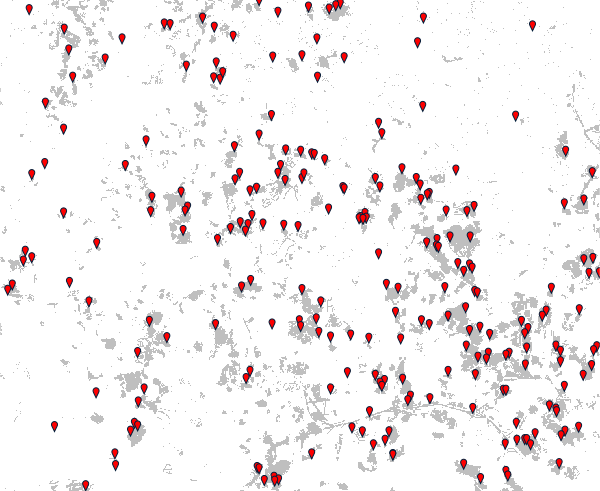

In [52]:
gs.run_command("g.region", n=1496445, s=1473765, e=1373865, w=1346175, save="zoomin")
m = gj.Map(saved_region="zoomin")
m.d_rast(map="urban_change")
m.d_vect(map="samples", size=10, fill_color="red", icon="basic/pin")
m.show()


### Potential
Runs r.futures.potential to select the "best" model and compute regression coefficients.
The best model selection runs in parallel (parallelized in R).

In [94]:
%%timeit -n1 -r5
gs.run_command(
    "r.futures.potential",
    input="samples",
    output="best_model.csv",
    columns=[
        "devpressure_2001",
        "log_dist_to_forest_2001",
        "log_dist_to_roads_2001",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    developed_column="urban_change",
    subregions_column="counties",
    random_column="devpressure_2001",
    min_variables=3,
    nprocs=nprocs,
    flags="d",
    dredge_output="all_models.csv",
)


8min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [83]:
%%timeit -n1 -r5
gs.run_command(
    "r.futures.potential",
    input="samples",
    output="best_model.csv",
    columns=[
        "devpressure_2001",
        "log_dist_to_forest_2001",
        "log_dist_to_roads_2001",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    developed_column="urban_change",
    subregions_column="counties",
    random_column="devpressure_2001",
    min_variables=3,
    nprocs=1,
    flags="d",
    dredge_output="all_models.csv",
)


18min 19s ± 3.23 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [55]:
pd.read_csv("all_models.csv", index_col=0)

Intercept  log_dist_to_forest_2001  log_dist_to_roads_2001  \
ID                                                               
31   1.115434                 0.044341               -0.506427   
30   1.370089                      NaN               -0.507744   
27   2.542447                 0.018183               -0.548408   
26   2.600362                      NaN               -0.546694   
23   0.758197                 0.086889               -0.535896   
22   1.237387                      NaN               -0.543044   
15   1.584655                 0.022640               -0.551631   
19   2.090219                 0.060984               -0.572131   
14   1.698768                      NaN               -0.551295   
11   2.546748                 0.008012               -0.570947   
29  -1.895679                 0.046045                     NaN   
7    1.182828                 0.063239               -0.574599   
28  -1.626715                      NaN                     NaN   
25  -0.265196                 0.003050                     NaN   
21  -2.498372                 0.094459                     NaN   
13  -1.543835                 0.018319                     NaN   

    log_dist_to_water     slope  wetland_density  df        logLik  \
ID                                                                   
31           0.194149 -0.110718        -2.836626   9 -34585.603542   
30           0.179279 -0.119725        -2.783506   8 -34627.918160   
27                NaN -0.105996        -2.481692   8 -34890.575987   
26                NaN -0.110109        -2.475330   7 -34898.179736   
23           0.181180       NaN        -2.715948   8 -35099.446640   
22           0.147918       NaN        -2.579782   7 -35275.713323   
15           0.138426 -0.103300              NaN   8 -35357.332207   
19                NaN       NaN        -2.385152   7 -35364.872406   
14           0.132428 -0.108092              NaN   7 -35368.731594   
11                NaN -0.100438              NaN   7 -35514.183858   
29           0.255649 -0.124593        -3.104048   8 -35794.752410   
7            0.127610       NaN              NaN   7 -35809.859406   
28           0.237801 -0.133772        -3.045878   7 -35842.324741   
25                NaN -0.118729        -2.553179   7 -36400.035455   
21           0.243902       NaN        -2.964326   7 -36501.423389   
13           0.180700 -0.116353              NaN   7 -36861.045307   

             AIC        delta         weight  
ID                                            
31  69189.207083     0.000000   1.000000e+00  
30  69271.836320    82.629237   1.141009e-18  
27  69797.151974   607.944891  9.692690e-133  
26  69810.359471   621.152388  1.313629e-135  
23  70214.893279  1025.686196  1.883963e-223  
22  70565.426646  1376.219563  1.437868e-299  
15  70730.664414  1541.457331   0.000000e+00  
19  70743.744813  1554.537730   0.000000e+00  
14  70751.463187  1562.256104   0.000000e+00  
11  71042.367716  1853.160633   0.000000e+00  
29  71605.504819  2416.297736   0.000000e+00  
7   71633.718812  2444.511729   0.000000e+00  
28  71698.649482  2509.442399   0.000000e+00  
25  72814.070910  3624.863827   0.000000e+00  
21  73016.846777  3827.639694   0.000000e+00  
13  73736.090614  4546.883531   0.000000e+00

In [56]:
pd.read_csv("best_model.csv", index_col=0)#.loc["37183"]


KeyError: '37183'

### Calibration
Here we derive the distribution of the historical patch sizes per county. r.futures.calib is internally parallelized,
so depending on the number of available cores, you can select 1 or more cores for each r.futures.calib run.

In [62]:
%%writefile calibration_for_state.py
import sys
import grass.script as gs

state = sys.argv[1]

gs.run_command("g.mapsets", mapset="tutorial", operation="add")
gs.run_command("g.region", raster=f"state_{state}")
gs.run_command(
    "r.futures.calib",
    flags="sl",
    development_start="urban_2001",
    development_end="urban_2019",
    subregions=f"state_{state}",
    patch_threshold=1800,
    patch_sizes=f"patch_sizes_{state}.csv",
    nprocs=1,
)


Overwriting calibration_for_state.py


In [63]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f calibration_jobs.sh
for S in 1 12 13 37 45 47
do
    echo grass8 --tmp-mapset FUTURES/ --exec python calibration_for_state.py ${S} >> calibration_jobs.sh
done
parallel -j ${1} < calibration_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

4
0.8


In [108]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f calibration_jobs.sh
for S in 1 12 13 37 45 47
do
    echo grass8 --tmp-mapset FUTURES/ --exec python calibration_for_state.py ${S} >> calibration_jobs.sh
done
parallel -j 1 < calibration_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

34001
6800.2


### Patch Growing Algorithm
Putting all the intermediate results together, we can now finally run the simulation from 2019 until 2050.

We restrict the memory consumption to 10 GB and we will run 3 simulations in parallel. r.futures.pga
will be executed many times (number of stochastic runs * number of states = 10 * 6 = 60).
If more memory is available, more cores can be used.

In [84]:
%%writefile simulation_for_state.py
import sys
import grass.script as gs

state, seed = sys.argv[1:3]

gs.run_command("g.mapsets", mapset="tutorial", operation="add")
gs.run_command("g.region", raster=f"state_{state}")
gs.run_command("r.mask", raster="masking")
gs.run_command(
    "r.futures.pga",
    developed="urban_2019",
    development_pressure="devpressure_2019",
    compactness_mean=0.3,
    compactness_range=0.1,
    discount_factor=0.5,
    predictors=[
        "log_dist_to_forest_2019",
        "log_dist_to_roads_2019",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    n_dev_neighbourhood=30,
    devpot_params="best_model.csv",
    num_neighbors=4,
    seed_search="probability",
    development_pressure_approach="gravity",
    gamma=0.5,
    scaling_factor=0.1,
    subregions=f"state_{state}",
    demand=f"demand_{state}.csv",
    num_steps=31,
    output=f"out_state_{state}_seed_{seed}",
    patch_sizes=f"patch_sizes_{state}.csv",
    incentive_power=2,
    random_seed=seed
)
gs.run_command("r.mask", flags="r")


Overwriting simulation_for_state.py


In [91]:
%%bash

rm -f pga_jobs.sh
for SEED in {2..3}
do
    for STATE in 1 12 13 37 45 47
    do
        rm -rf FUTURES/pga_${STATE}_${SEED}
        echo grass8 -c FUTURES/pga_${STATE}_${SEED} --exec python simulation_for_state.py ${STATE} ${SEED} >> pga_jobs.sh
    done
done
parallel -j 6 < pga_jobs.sh #2> log.txt


Process is terminated.


In [95]:
%%bash
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f pga_jobs.sh
for SEED in {1..10}
do
    for STATE in 1 12 13 37 45 47
    do
        rm -rf FUTURES/pga_${STATE}_${SEED}
        echo grass8 -c FUTURES/pga_${STATE}_${SEED} --exec python simulation_for_state.py ${STATE} ${SEED} >> pga_jobs.sh
    done
done
parallel -j 6 < pga_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

15939
3187.8


In [98]:
%%bash
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f pga_jobs.sh
for SEED in {1..10}
do
    for STATE in 1 12 13 37 45 47
    do
        rm -rf FUTURES/pga_${STATE}_${SEED}
        echo grass8 -c FUTURES/pga_${STATE}_${SEED} --exec python simulation_for_state.py ${STATE} ${SEED} >> pga_jobs.sh
    done
done
parallel -j 1 < pga_jobs.sh 2> log.txt
done

elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

91328
18265.6


Afterwards, we patch the results together. Tool r.patch is internally parallelized, so we can use that extra speed up is we have available cores.

In [96]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f patch_jobs.sh
for SEED in {1..10}
do
    MAPS=$(grass8 --tmp-mapset FUTURES/ --exec \
           g.list type=raster pattern="out_state_*_seed_${SEED}" mapset="*" -m separator=comma)
    rm -rf FUTURES/results_${SEED}
    echo grass8 -c FUTURES/results_${SEED} --exec r.patch input=${MAPS} output="out_seed_${SEED}" nprocs=2 >> patch_jobs.sh
done
parallel -j ${1} < patch_jobs.sh 2> log.txt
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

438
87.6


Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_a0c7aa7d8ce3492380d13d432d6823f5>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_1 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_1 mapset=* -m separator=comma> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_d597ffe38f994d1a8b06f5188ae38b1b>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_2 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_2 mapset=* -m separator=comma> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_dac069fa92164c46ac77c51052e4134d>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_3 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_3 mapset=* -m separator=comma> finish

In [97]:
%%bash -s "{int(nprocs/2)}"
start_time=$SECONDS
for I in 1 2 3 4 5
do
rm -f patch_jobs.sh
for SEED in {1..10}
do
    MAPS=$(grass8 --tmp-mapset FUTURES/ --exec \
           g.list type=raster pattern="out_state_*_seed_${SEED}" mapset="*" -m separator=comma)
    rm -rf FUTURES/results_${SEED}
    echo grass8 -c FUTURES/results_${SEED} --exec r.patch input=${MAPS} output="out_seed_${SEED}" nprocs=1 >> patch_jobs.sh
done
parallel -j 1 < patch_jobs.sh 2> log.txt
done
elapsed=$(( SECONDS - start_time ))
echo $elapsed
python -c "print( $elapsed / float(5) )"

3438
687.6


Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_0b941bb68cb44f65bfc3953907237315>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_1 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_1 mapset=* -m separator=comma> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_5b0de2a652834f139ae567e732f0b55a>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_2 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_2 mapset=* -m separator=comma> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS mapset <tmp_4f5d9fa9c31144b78f856fb5b85c7486>...
Cleaning up temporary files...
Executing <g.list type=raster pattern=out_state_*_seed_3 mapset=* -m separator=comma> ...
Execution of <g.list type=raster pattern=out_state_*_seed_3 mapset=* -m separator=comma> finish

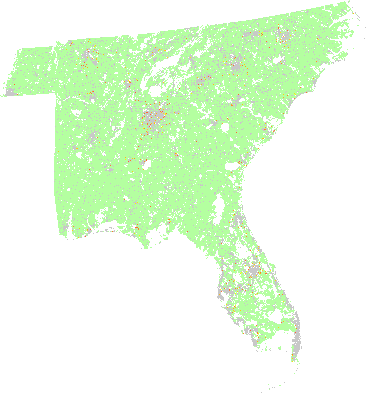

In [101]:
m = gj.Map()
m.d_rast(map="out_seed_1@results_1")
m.show()


### Future Development Probability
By aggregating the stochastic runs we can compute the projected development probability. First we reclassify output
to binary developed/undeveloped results. Then we run r.series in parallel to compute how many times a cell was developed
and then divide that by number of runs.

In [ ]:
%%writefile reclass.txt
-1 0 = 0
1 thru 100 = 1
* = 0


In [ ]:
for seed in range(1, 11):
    gs.run_command(
        "r.reclass",
        input=f"out_seed_{seed}@results_{seed}",
        output=f"out_seed_{seed}",
        rules="reclass.txt",
    )
gs.run_command(
    "r.series",
    input=[f"out_seed_{seed}" for seed in range(1, 11)],
    output="sum",
    method="sum",
    weights=[0.1] * 10,
    nprocs=nprocs,
)


In [99]:
%%timeit -n1 -r5
gs.run_command(
    "r.series",
    input=[f"out_seed_{seed}" for seed in range(1, 11)],
    output="probability",
    method="sum",
    weights=[0.1] * 10,
    nprocs=nprocs,
)

1min 2s ± 357 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [100]:
%%timeit -n1 -r5
gs.run_command(
    "r.series",
    input=[f"out_seed_{seed}" for seed in range(1, 11)],
    output="sum",
    method="sum",
    weights=[0.1] * 10,
    nprocs=1,
)

5min 58s ± 188 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


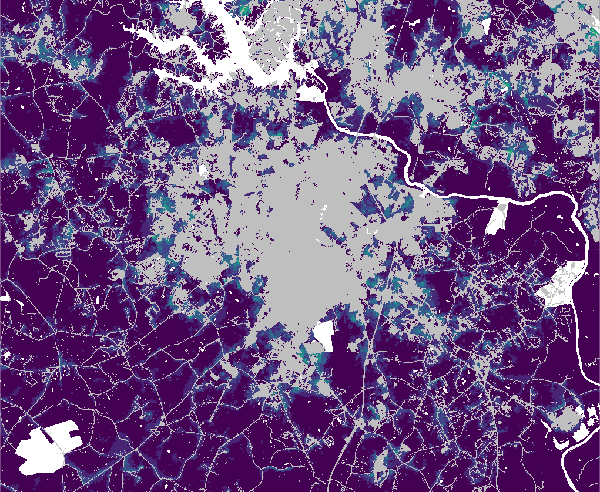

In [102]:
gs.run_command("g.region", n=1439421, s=1414322, w=1335588, e=1366210, align="probability", save="zoomin2")
m = gj.Map(saved_region="zoomin2")
m.d_rast(map="probability")
m.d_rast(map="urban_2019", values=1)
m.show()

## Forest loss analysis
Here we compute future forest loss due to development, demonstrating how to parallelize computations using Python multiprocessing.
The goal is to compute forest loss for each of 30x30 km tiles in parallel across the landscape to capture large scale forest loss patterns.
To do that we use `GRASS_REGION` environmental variable and set different region for each seed and tile combination.

We will run this as a Python script (not directly from the cell) because Python multiprocessing sometimes doesn't work well within a Jupyter Notebook.
Results that include tile coordinate, seed, and number of forest cells are written as JSON to a file.

In [132]:
%%writefile forest_loss.py
import os
import sys
import json
from math import ceil
from multiprocessing import Pool

import grass.script as gs
from grass.exceptions import CalledModuleError


def forest_loss_stats(params):
    """Compute projected forest loss for selected area.
    This function can be safely run in parallel."""
    seed, region = params
    # create unique temporary map names
    forest_loss = f"forest_{seed}_{region['n']}_{region['e']}"
    # copy and modify environment to change region based on input
    env = os.environ.copy()
    env["GRASS_REGION"] = gs.region_env(align="forest", **region)
    # pass the environment, so that the computations run with different region than the current one
    # compute lost forest comparing to 2019
    gs.mapcalc(
        f"{forest_loss} = if (forest_2019 && out_seed_{seed}@results_{seed} >= 0, 1, 0)",
        env=env,
        quiet=True,
    )
    # get number of cells for 0 (no change) and 1 (forest lost) category
    results = dict(
        gs.parse_command(
            "r.stats",
            input=forest_loss,
            flags="cn",
            parse=(gs.parse_key_val, {"sep": " ", "val_type": int}),
            env=env,
            quiet=True,
        )
    )
    # add N, E as a center of the region, and add seed to results
    results["n"] = (region["n"] + region["s"]) / 2
    results["e"] = (region["e"] + region["w"]) / 2
    results["seed"] = seed
    # remove temporary maps
    gs.run_command("g.remove", type="raster", name=forest_loss, flags="f", quiet=True)
    # return dictionary with results
    return results


if __name__ == "__main__":
    nproc = int(sys.argv[1])
    current = gs.region()
    regions = []
    tile = 1000
    # create a region where each cell is a 30x30 km tile
    gs.run_command("g.region", res=tile * current["nsres"], flags="a", save="tiles")
    env = os.environ.copy()
    env["GRASS_REGION"] = gs.region_env(region="tiles")
    grid_region = gs.region(env=env)
    # save extents of each tile
    for row in range(int(grid_region["rows"])):
        for col in range(int(grid_region["cols"])):
            s = float(grid_region["s"]) + row * float(grid_region["nsres"])
            n = float(grid_region["s"]) + (row + 1) * float(grid_region["nsres"])
            w = float(grid_region["w"]) + col * float(grid_region["ewres"])
            e = float(grid_region["w"]) + (col + 1) * float(grid_region["ewres"])
            regions.append(
                {
                    "n": n,
                    "s": s,
                    "w": w,
                    "e": e,
                }
            )

    params = []
    # collect parameters (for each seed and tile)
    for seed in range(1, 11):
        for region in regions:
            params.append((seed, region))
    if nproc == 1:
        results = []
        for param in params:
            results.append(forest_loss_stats(param))
        with open("forest_results.json", "w") as f:
            json.dump(results, f)
        
    else:
        # execute forest loss computation for each tile in parallel
        with Pool(processes=nproc) as pool:
            results = pool.map_async(forest_loss_stats, params).get()
            # write results as json to file
            with open("forest_results.json", "w") as f:
                json.dump(results, f)


Overwriting forest_loss.py


In [133]:
nprocs

12

Execute the file with number of processes as an input:

In [134]:
%%timeit -n1 -r5
%run forest_loss.py {nprocs}


10min 38s ± 178 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [135]:
%%timeit -n1 -r5
%run forest_loss.py 1

2h 21min 53s ± 7.57 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


Load results, process them with Pandas and write a raster:

In [106]:
with open("forest_results.json", "r") as f:
    results = json.load(f)

df = pd.DataFrame(results)
df = df[df["1"].notna()].groupby(["n", "e"])[["1"]].mean()
df["km"] = df["1"] * 900 / 1000000

csv = df.drop(columns=["1"]).to_csv(index=True, header=False)
env = os.environ.copy()
env["GRASS_REGION"] = gs.region_env(region="tiles")
gs.write_command(
    "r.in.xyz",
    stdin=csv,
    input="-",
    x=2,
    y=1,
    output="forest_loss",
    method="mean",
    separator="comma",
    env=env,
)
gs.run_command("r.colors", map="forest_loss", color="forest_cover")


Visualize:

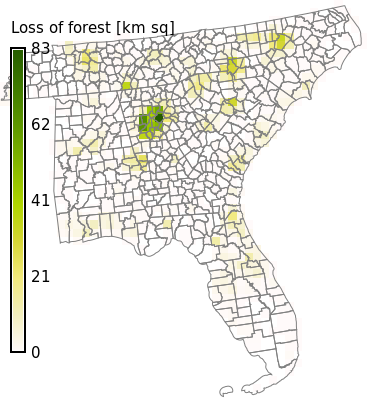

In [107]:
m = gj.Map()
m.d_rast(map="forest_loss")
m.d_vect(map="SE_counties", fill_color="none", color="grey")
m.d_legend(raster="forest_loss", title="Loss of forest [km sq]")
m.show()
